# Multi-Layer Perceptron (MLP)

In logistic regression, the transformation was done with a fully-connected layer, which consisted of a linear transform (matrix multiply plus a bias). 

A neural network consisting of multiple successive fully-connected layers is commonly called a Multi-Layer Perceptron (MLP). In the simple MLP below, a 4-d input is projected to a 5-d hidden representation, which is then projected to a single output that is used to make the final prediction.

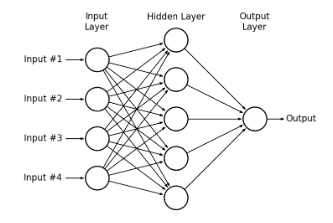

Below the code for creating an MLP for the MNIST dataset is presented. The changes include creating a hidden layer of 500 dimensions before transforming to a 10-d output vector.

Nonlinearities are included between layers of the neural network to prevent successive linear transforms to collapse into a single linear transform. This is done using the `relu(x)` function in `torch.nn.functional`.

Details on [rectified linear unit (ReLU)](https://en.wikipedia.org/wiki/Rectifier_(neural_networks))

The mathematical equation is as follows:

\begin{align}
x = \max(0,x)
\end{align}

Note that it can also be done without `torch.nn.functional`:

In [1]:
import torch

x = torch.rand(5, 3)*2 - 1
x_relu_max = torch.max(torch.zeros_like(x),x)

print("x: {}".format(x))
print("x after ReLU with max: {}".format(x_relu_max))

x: tensor([[ 0.0855, -0.5941, -0.0688],
        [ 0.1229, -0.3726, -0.3102],
        [-0.5807, -0.4086, -0.5239],
        [-0.2327,  0.2717, -0.1571],
        [-0.2856,  0.8921,  0.5478]])
x after ReLU with max: tensor([[0.0855, 0.0000, 0.0000],
        [0.1229, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.2717, 0.0000],
        [0.0000, 0.8921, 0.5478]])


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

class MNIST_MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(784, 500) # Hidden Layer 1
        self.output = nn.Linear(500, 10) # Output Layer

    def forward(self, x):
        x = F.relu(self.hidden1(x)) # Activation function for first hidden layer
        x = self.output(x) # No activation function for output layer
        return x

# Load the data
mnist_train = datasets.MNIST(root="./datasets", train=True, transform=transforms.ToTensor(), download=True)
mnist_test = datasets.MNIST(root="./datasets", train=False, transform=transforms.ToTensor(), download=True)
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=100, shuffle=False)

## Training
# Instantiate model
model = MNIST_MLP()

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

# Iterate through train set minibatchs 
for images, labels in tqdm(train_loader):
    # Zero out the gradients
    optimizer.zero_grad()
    
    # Forward pass
    x = images.view(-1, 28*28)
    y = model(x)
    loss = criterion(y, labels)
    # Backward pass
    loss.backward()
    optimizer.step()

## Testing
correct = 0
total = len(mnist_test)

with torch.no_grad():
    # Iterate through test set minibatchs 
    for images, labels in tqdm(test_loader):
        # Forward pass
        x = images.view(-1, 28*28)
        y = model(x)
        
        predictions = torch.argmax(y, dim=1)
        correct += torch.sum((predictions == labels).float())
    
print('Test accuracy: {}'.format(correct/total))

I can also adjust the learning rate as well as the number of epochs in order to get better results.

**Impact of Learning Rate**

Learning Rate controls the size of the steps the optimizer takes when adjusting the weights of the model during training.

Convergence Speed:

- High Learning Rate: If the learning rate is too high, the model may converge very quickly but can overshoot the optimal solution, causing the loss to fluctuate or even diverge. This can prevent the model from reaching the best possible accuracy.
- Low Learning Rate: If the learning rate is too low, the model will take very small steps towards the optimal solution, resulting in slow convergence. This can lead to a longer training time and may also cause the model to get stuck in local minima.

Stability of Training:

- High Learning Rate: With a high learning rate, the updates to the model parameters are large, which can lead to instability in training. The loss might not decrease consistently, and the model might not learn effectively.
- Low Learning Rate: With a low learning rate, the updates are small and more controlled, which generally leads to more stable training. However, if the learning rate is too low, the model might need an excessive amount of time to converge.

Final Model Performance:

- High Learning Rate: Can result in suboptimal performance due to overshooting and instability.
- Low Learning Rate: Can also result in suboptimal performance if the model converges too slowly and does not reach the optimal solution within the given number of epochs.

To choose appropriate learning rate, can use **Learning Rate Schedulers** like `StepLR`, `ReduceLROnPlateau`, and `ExponentialLR` which reduces learning rate after a certain number of epochs/when validation loss plateaus.

**Impact of Number of Epochs**

Number of Epochs defines how many times the learning algorithm will work through the entire training dataset.

Underfitting vs. Overfitting:

- Underfitting: If the number of epochs is too low, the model might not have enough opportunity to learn from the data. This can result in underfitting, where the model performs poorly on both training and validation datasets because it has not captured the underlying patterns in the data.
- Overfitting: If the number of epochs is too high, the model might learn the training data too well, including its noise and outliers. This can result in overfitting, where the model performs very well on the training data but poorly on the validation or test data because it has not generalized well.

Convergence:

- The model's performance typically improves with more epochs as it has more opportunities to adjust its weights and reduce the loss. However, after a certain point, additional epochs may result in diminishing returns or even degrade performance if overfitting occurs.

Training Time:

- More epochs mean longer training times. It’s essential to balance the number of epochs to ensure that the model trains for an adequate amount of time without wasting resources on unnecessary training.


To choose right number of epochs, can do **Early Stopping** which monitors the model's performance on a validation set and stops the training process when performance stops improving.

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
from tqdm.notebook import tqdm

class MNIST_MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(784, 500) # Hidden Layer 1
        self.output = nn.Linear(500, 10) # Output Layer

    def forward(self, x):
        x = F.relu(self.hidden1(x)) # Activation function for first hidden layer
        x = self.output(x) # No activation function for output layer
        return x

# Lists to store loss values
train_losses = []
val_losses = []
    
# Define transformations
transform = transforms.ToTensor()

# Load the dataset
mnist_train = datasets.MNIST(root="./datasets", train=True, transform=transform, download=True)
mnist_test = datasets.MNIST(root="./datasets", train=False, transform=transform, download=True)

# Create training and validation sets
num_train = len(mnist_train)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(0.8 * num_train)  # 80% for training, 20% for validation
train_idx, val_idx = indices[:split], indices[split:]

train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=100, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(mnist_train, batch_size=100, sampler=val_sampler)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=100, shuffle=False)


## Training

# Instantiate model
model = MNIST_MLP()

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1) ## Learning rate scheduler

# Set the number of epochs and early stopping criteria
num_epochs = 50
patience = 5
best_val_loss = float('inf')
early_stop_counter = 0
final_num_epoch = 0

# Training
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    train_loss = 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        # Zero out the gradients
        optimizer.zero_grad()
        
        # Forward pass
        x = images.view(-1, 28*28)  # Flatten the images
        y = model(x)
        loss = criterion(y, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    scheduler.step()  # Adjust the learning rate
    
    average_train_loss = train_loss / len(train_loader)
    train_losses.append(average_train_loss)  # Average training loss for the epoch
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {average_train_loss:.4f}')

    # Validation
    model.eval()  # Set the model to evaluation mode
    val_loss = 0
    correct = 0
    total = len(mnist_test)
    with torch.no_grad():
        for images, labels in val_loader:
            # Forward pass
            x = images.view(-1, 28*28)  # Flatten the images
            y = model(x)
            val_loss += criterion(y, labels).item()
            predictions = torch.argmax(y, dim=1)
            correct += torch.sum((predictions == labels).float())
            
    val_losses.append(val_loss / len(val_loader))
    val_loss /= len(test_loader)
    accuracy = correct / total
    
    print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}, Test accuracy: {accuracy:.4f}, Learning rate: {scheduler.get_last_lr()[0]}')
    
    # Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1
    
    if early_stop_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        final_num_epoch = epoch+1
        break
        
# Plotting
plt.plot(range(1, final_num_epoch + 1), train_losses, label='Training Loss')
plt.plot(range(1, final_num_epoch + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()
        
# Testing
model.eval()  # Set the model to evaluation mode
correct = 0
total = len(mnist_test)
with torch.no_grad():
    for images, labels in test_loader:
        # Forward pass
        x = images.view(-1, 28*28)  # Flatten the images
        y = model(x)
        predictions = torch.argmax(y, dim=1)
        correct += torch.sum((predictions == labels).float())
    
test_accuracy = correct / total
print(f'Test accuracy: {test_accuracy:.4f}')        


Epoch 1/50:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 1/50, Training Loss: 0.5577
Epoch 1/50, Validation Loss: 0.3875, Test accuracy: 1.0894, Learning rate: 0.1


Epoch 2/50:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 2/50, Training Loss: 0.2823


KeyboardInterrupt: 

Number of trainable parameters for MLP:

- Hidden Layer: 784 x 500 + 500 = 392500
- Output Layer: 500 x 10 + 10 = 5010

(First term is weights, second term is biases)

Total: 397510

Number of trainable parameters for Logistic Regression:

Linear Layer: 784 x 10 + 10 = 7850